# Exercise 1: ImageNet classification

## Inspecting ImageNet


- Link to the dataset: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php

## 1) Installing Libraries

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch,torchvision,lightning --conda

/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

numpy      : 1.23.5
pandas     : 1.5.3
matplotlib : 3.7.0
torch      : 2.0.1
torchvision: 0.15.2
lightning  : 2.0.5

conda environment: base



## 1.1) Reorganizing val folder so it is recognizable by `datasets.ImageFolder`

In [ ]:
import os


# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

## 2) Loading the dataset

In [2]:
import lightning as L
from local_utilities import ImageNetDataModule

In [3]:
dm = ImageNetDataModule(data_path='tiny-imagenet-200',batch_size=64, num_workers=4)

In [4]:
dm.setup()
dm.train_dataloader()

In [5]:
len(dm.train)

95000

In [6]:
len(dm.valid)

5000

In [7]:
len(dm.test)

10000

In [ ]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

### Check label distribution

In [9]:
from collections import Counter

train_counter = Counter()
for images, labels in dm.train_dataloader():
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

    
val_counter = Counter()
for images, labels in dm.val_dataloader():
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    

test_counter = Counter()
for images, labels in dm.test_dataloader():
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 478), (1, 470), (2, 469), (3, 473), (4, 472), (5, 483), (6, 478), (7, 472), (8, 467), (9, 473), (10, 471), (11, 483), (12, 476), (13, 470), (14, 482), (15, 480), (16, 481), (17, 478), (18, 474), (19, 466), (20, 475), (21, 477), (22, 476), (23, 471), (24, 477), (25, 467), (26, 468), (27, 477), (28, 477), (29, 472), (30, 473), (31, 481), (32, 475), (33, 470), (34, 483), (35, 483), (36, 476), (37, 469), (38, 471), (39, 473), (40, 467), (41, 475), (42, 475), (43, 480), (44, 476), (45, 474), (46, 468), (47, 479), (48, 469), (49, 488), (50, 479), (51, 475), (52, 481), (53, 476), (54, 475), (55, 480), (56, 480), (57, 480), (58, 470), (59, 476), (60, 471), (61, 476), (62, 470), (63, 476), (64, 475), (65, 478), (66, 479), (67, 467), (68, 480), (69, 480), (70, 475), (71, 470), (72, 477), (73, 475), (74, 475), (75, 477), (76, 469), (77, 479), (78, 479), (79, 476), (80, 468), (81, 479), (82, 478), (83, 476), (84, 478), (85, 483), (86, 470), (87, 476), (88, 479), 

## 3) Zero-rule baseline (majority class classifier)

In [12]:
majority_class = val_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 182
Accuracy when always predicting the majority class:
0.00 (0.40%)


## 4) A quick visual check

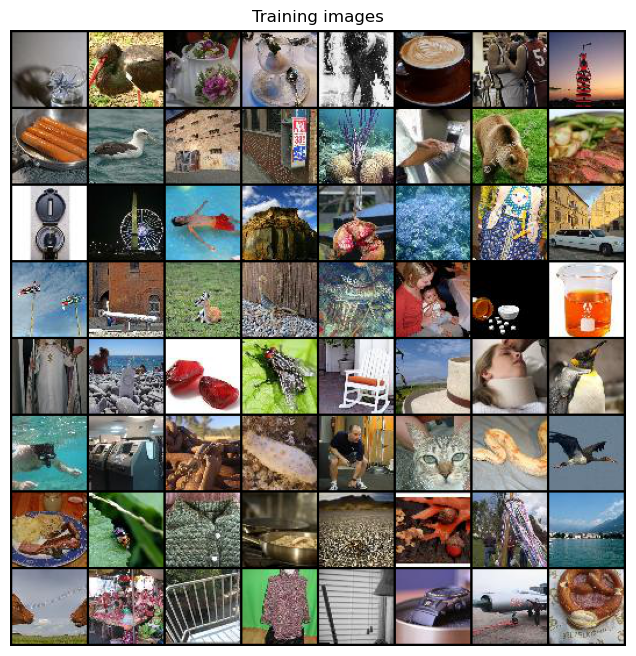

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck